# Series Temporales

In [ ]:
defunciones = pd.read_excel('defunciones.xlsx')
defunciones.info()
#defunciones.head()

In [71]:
defunciones = defunciones.rename(columns={' ': 'fecha'})

#Convertir a tipo string para manipular el formato
defunciones.fecha = defunciones.fecha.astype('string')

# Reemplazar la M por un guion en la columna de fechas
defunciones['fecha'] = defunciones['fecha'].str.replace('M', '-')

# Convertir la columna de fechas en formato de fecha y hora
defunciones['fecha'] = pd.to_datetime(defunciones['fecha'], format='%Y-%m')

# Convertir la columna de fechas en el formato deseado
defunciones['fecha'] = defunciones['fecha'].dt.strftime('%Y-%m')
# convertir la columna fecha en index
defunciones.set_index(['fecha'],inplace=True)

#Convertirla en index de tipo fecha para que sea reconocida como serie temporal
defunciones.index=pd.to_datetime(defunciones.index)

defunciones.head()

,Todas las causas,Tumores,Causas externas
fecha,,,
1980-01-01,28681,4883,1277
1980-02-01,23906,4493,1122
1980-03-01,25275,4957,1244
1980-04-01,22500,4523,1214
1980-05-01,22781,4893,1228


En este caso se elegirá la serie de Tumores para ser evaluada

In [72]:
defunciones.drop(['Causas externas', 'Todas las causas'], axis=1, inplace=True)
defunciones.head()

,Tumores
fecha,
1980-01-01,4883
1980-02-01,4493
1980-03-01,4957
1980-04-01,4523
1980-05-01,4893


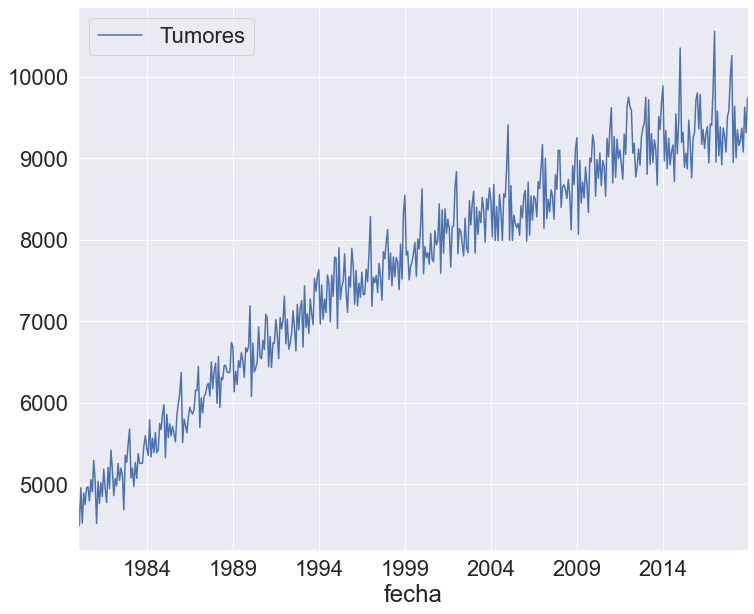

In [73]:
plt.rcParams["figure.figsize"] = (12,10)
defunciones.plot()
plt.show()

Existe una clara tendencia alcista en la serie de Tumores, por lo que se descarta inmediatamente que esta sea estacionaria. Por otro lado, se observan comportamientos cíclicos que podrían indicar que la varianza no es constante a lo lardo de la serie, esta hipótesis se intentara respaldar próximamente.

In [74]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression='ct')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(defunciones)

Results of Dickey-Fuller Test:
Test Statistic                  -0.373400
p-value                          0.987651
#Lags Used                      11.000000
Number of Observations Used    456.000000
Critical Value (1%)             -3.978761
Critical Value (5%)             -3.420162
Critical Value (10%)            -3.132739
dtype: float64


Utilizando el test de Dicky Fuller (con el argumento regression = 'ct', ya que hay una tendencia clara), se comprueba que la H0, es decir que la serie de Tumores no es estacionaria.

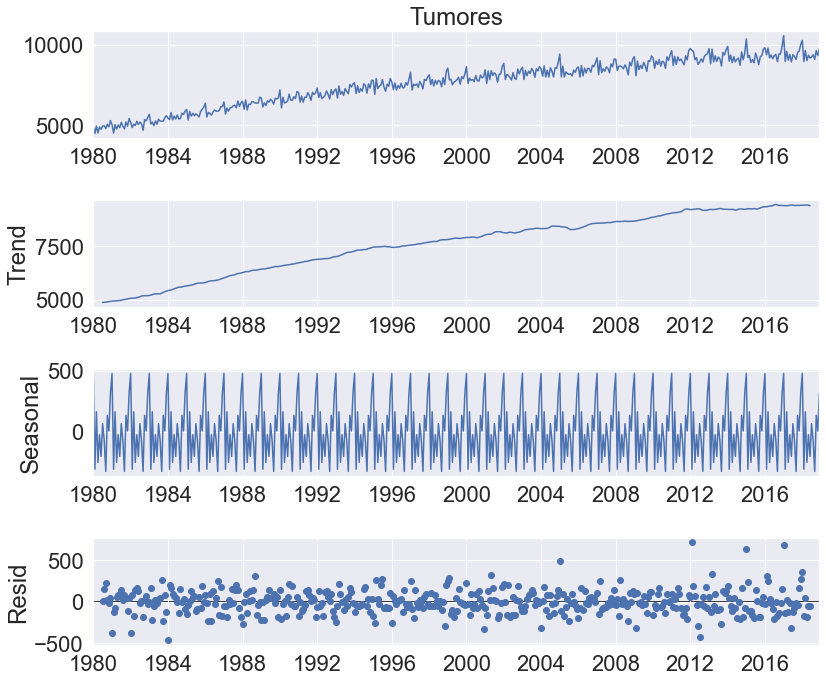

In [75]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aplicar descomposición aditiva
defunciones_desc_Ad = seasonal_decompose(defunciones['Tumores'], model='additive', period=12)
defunciones_desc_Ad.plot()
plt.show()

In [76]:
test_stationarity(defunciones_desc_Ad.resid.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -8.913262e+00
p-value                        5.704945e-13
#Lags Used                     1.700000e+01
Number of Observations Used    4.380000e+02
Critical Value (1%)           -3.979589e+00
Critical Value (5%)           -3.420561e+00
Critical Value (10%)          -3.132974e+00
dtype: float64


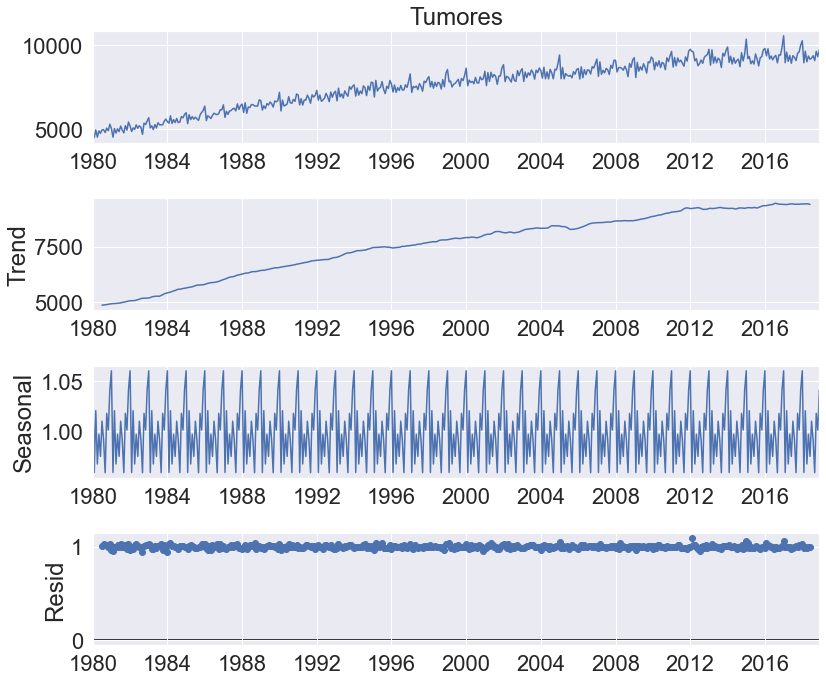

In [77]:
defunciones_desc_Mul = seasonal_decompose(defunciones['Tumores'], model='multiplicative', period=12)
defunciones_desc_Mul.plot()
plt.show()

In [78]:
test_stationarity(defunciones_desc_Mul.resid.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -9.081083e+00
p-value                        2.381654e-13
#Lags Used                     1.700000e+01
Number of Observations Used    4.380000e+02
Critical Value (1%)           -3.979589e+00
Critical Value (5%)           -3.420561e+00
Critical Value (10%)          -3.132974e+00
dtype: float64


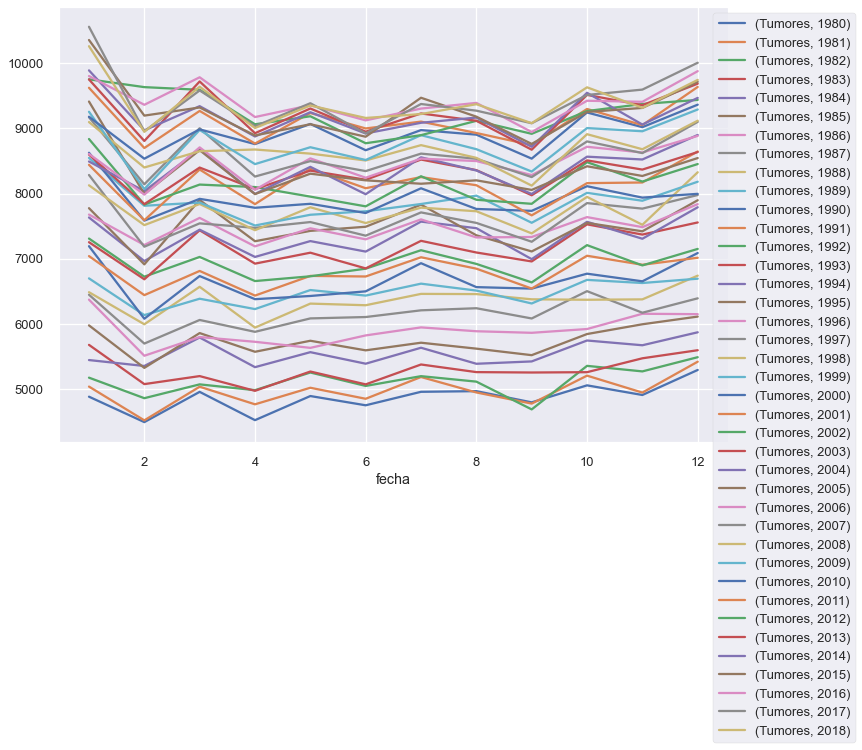

In [197]:
seasonal_plot(defunciones)
plt.legend(loc='upper right', bbox_to_anchor=(1.20, 1)) 
plt.show()

No parece haber una estacionariedad tan obvia, eso si, se observa que en la mayoria de los meses impares y en el mes de diciembre, hay mayor incidencia de defuunciones a causa de tumores que en los demas meses (principalmente en diciembre), y que cadas ano aumentan las defunciones a causa de los tumores.

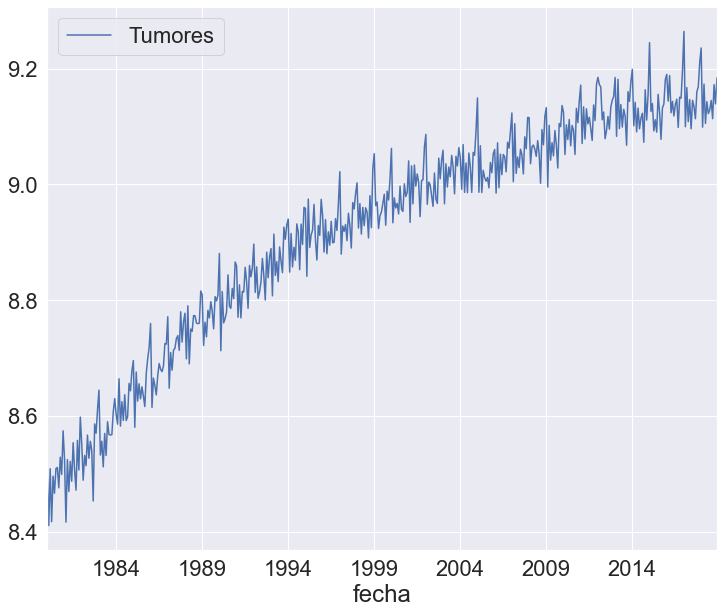

In [80]:
defunciones_log= np.log(defunciones)
defunciones_log.plot()
plt.show()

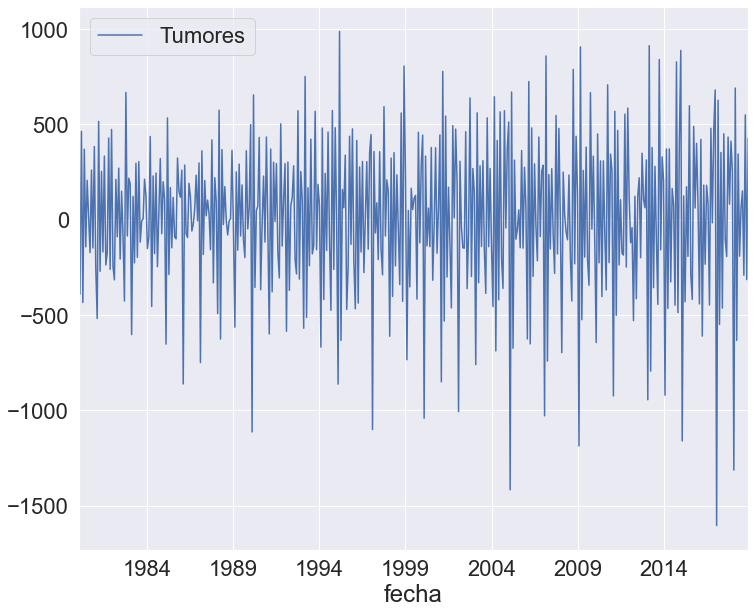

In [81]:
defunciones_diff_1 = defunciones.diff(periods=1)
defunciones_diff_1.plot()
plt.show()

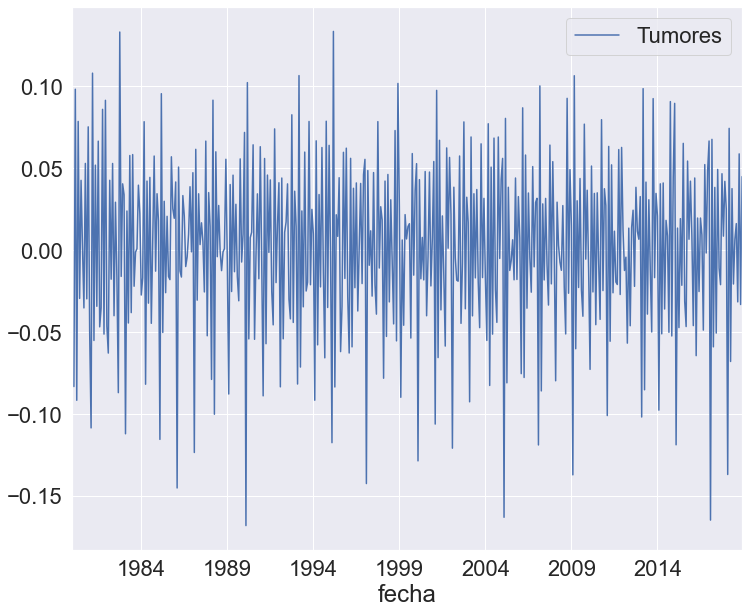

In [82]:
defunciones_log_diff_1 = defunciones_log.diff(periods=1)
defunciones_log_diff_1.plot()
plt.show()

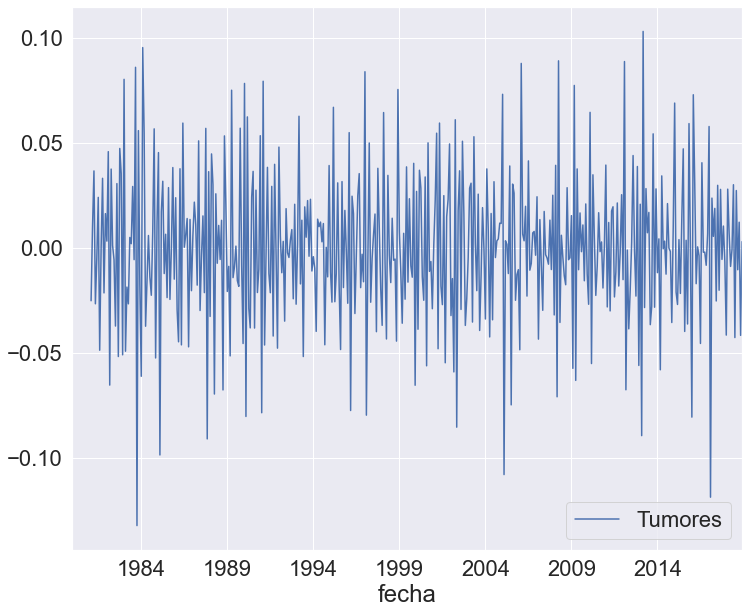

In [83]:
defunciones_log_diff_1_12 = defunciones_log_diff_1.diff(periods=12)
defunciones_log_diff_1_12.plot()
plt.show()

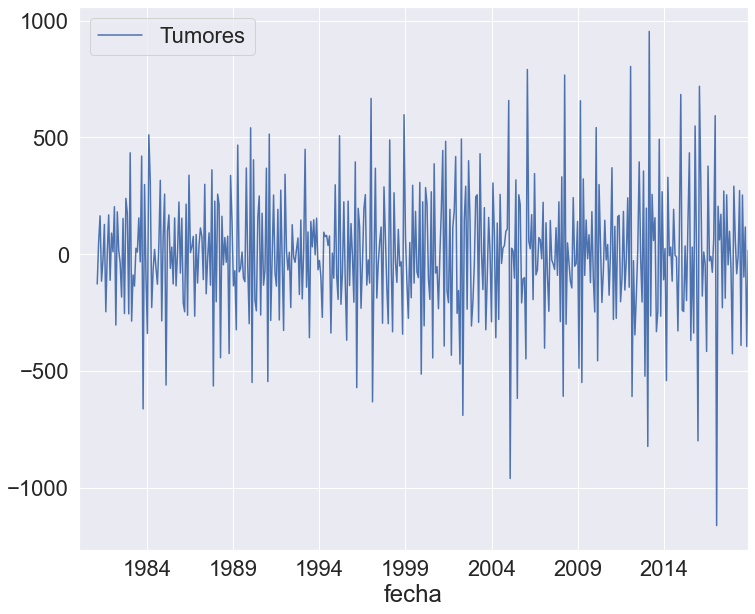

In [84]:
defunciones_diff_1_12 = defunciones_diff_1.diff(periods=12)
defunciones_diff_1_12.plot()
plt.show()

In [85]:
test_stationarity(defunciones_diff_1_12.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -9.923908e+00
p-value                        3.348517e-15
#Lags Used                     1.800000e+01
Number of Observations Used    4.360000e+02
Critical Value (1%)           -3.979685e+00
Critical Value (5%)           -3.420608e+00
Critical Value (10%)          -3.133001e+00
dtype: float64


In [86]:
test_stationarity(defunciones_log_diff_1_12.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -9.999930e+00
p-value                        2.307979e-15
#Lags Used                     1.800000e+01
Number of Observations Used    4.360000e+02
Critical Value (1%)           -3.979685e+00
Critical Value (5%)           -3.420608e+00
Critical Value (10%)          -3.133001e+00
dtype: float64


In [87]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

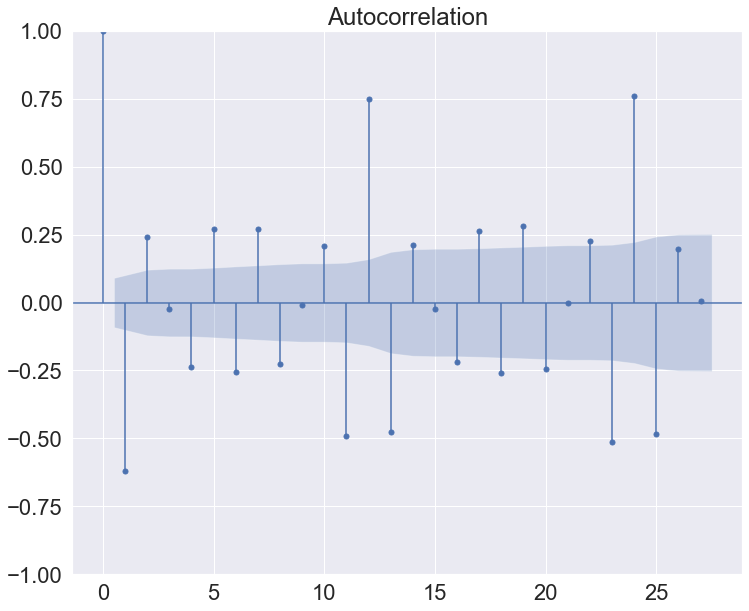

In [88]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(defunciones_diff_1.dropna(inplace=False))
plt.show()

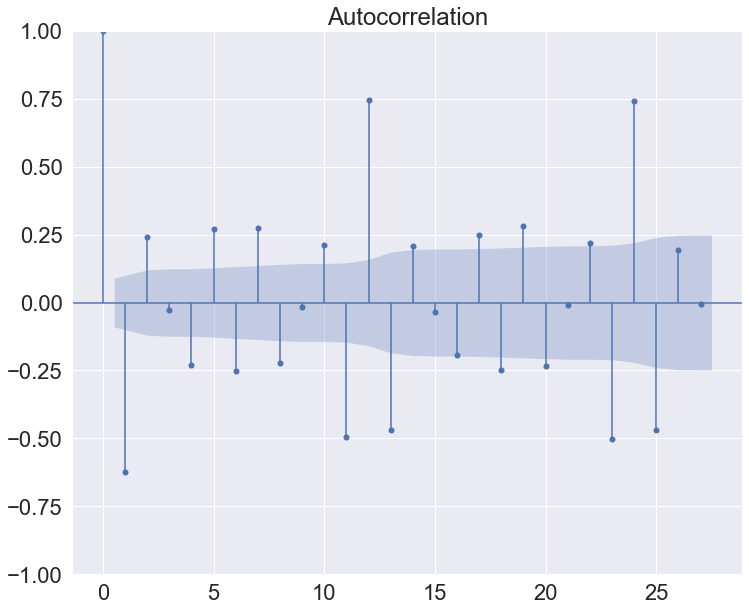

In [89]:
plot_acf(defunciones_log_diff_1.dropna(inplace=False))
plt.show()

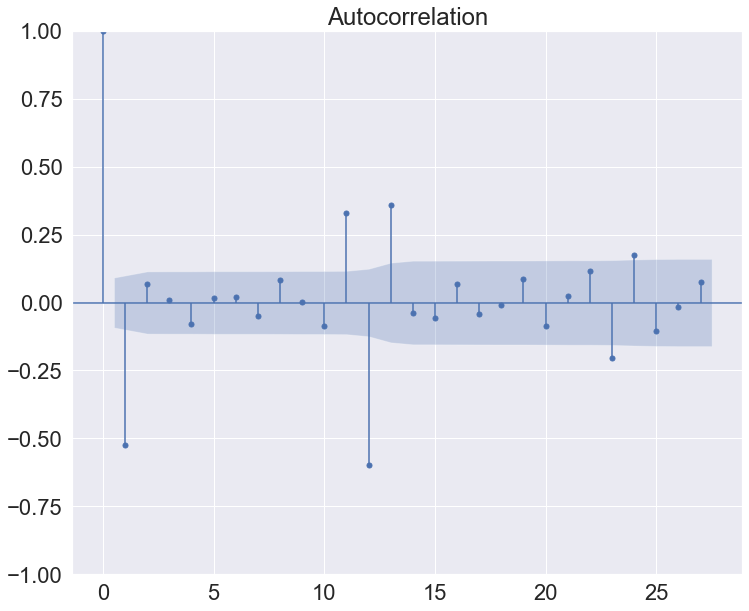

In [90]:
plot_acf(defunciones_diff_1_12.dropna(inplace=False))
plt.show()

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



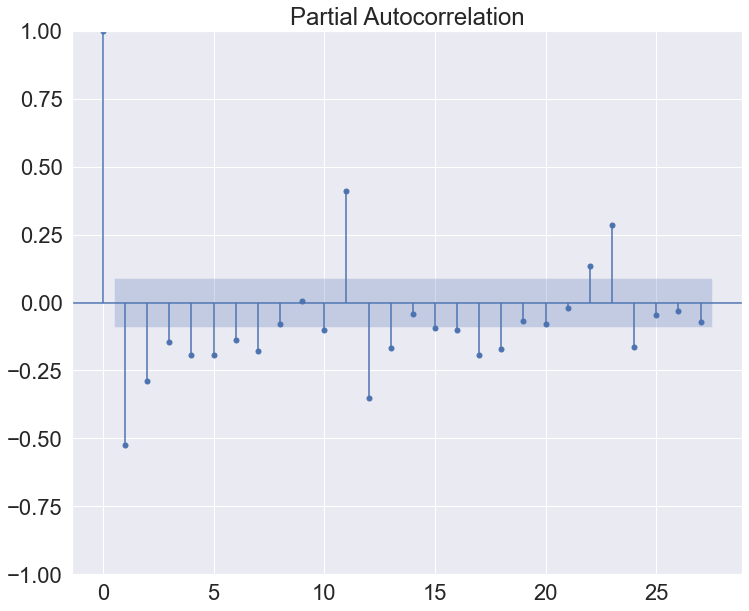

In [91]:
plot_pacf(defunciones_diff_1_12.dropna(inplace=False))
plt.show()

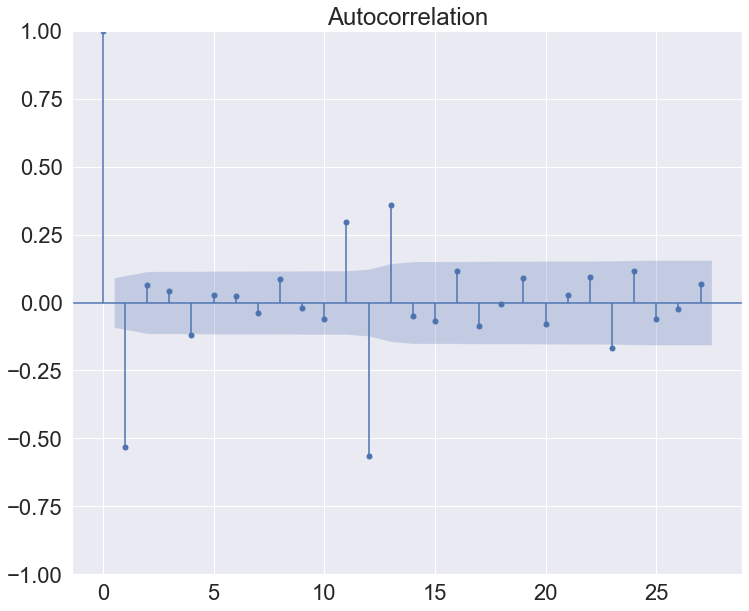

In [92]:
plot_acf(defunciones_log_diff_1_12.dropna(inplace=False))
plt.show()

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



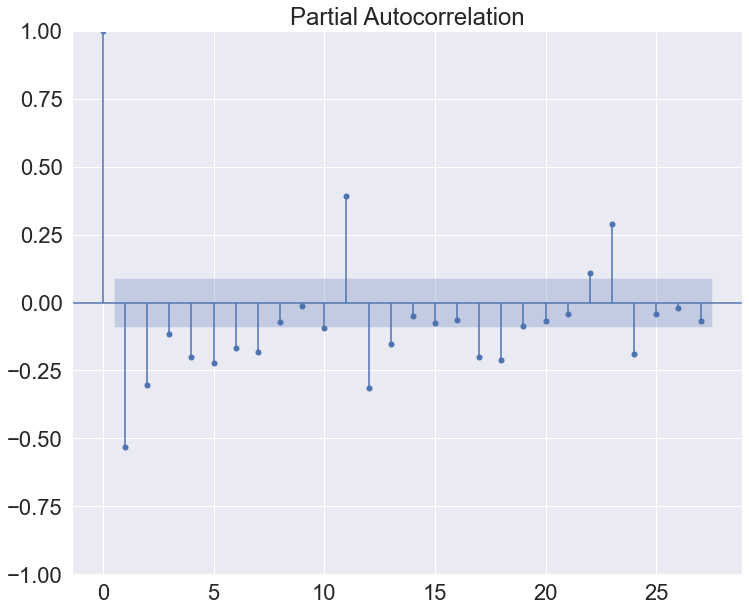

In [93]:
plot_pacf(defunciones_log_diff_1_12.dropna(inplace=False))
plt.show()

Para reciclar los gráficos y no hacer más extenso de la cuenta (que ya lo es) este archivo, se aprovecha para estimar un posible modelo Arima:
Modelo (2,1,2) (2,1,1)[12]


In [94]:
sm.stats.acorr_ljungbox(defunciones_diff_1_12.dropna(inplace=False), lags=12, return_df=True)

,lb_stat,lb_pvalue
1,126.071561,2.965929e-29
2,128.213645,1.441321e-28
3,128.240423,1.294930e-27
4,131.206516,2.149625e-27
5,131.344447,1.233768e-26
6,131.539805,6.091486e-26
7,132.612492,1.787747e-25
8,135.855185,1.724751e-25
9,135.855189,7.388527e-25
10,139.286488,5.901012e-25


In [95]:
sm.stats.acorr_ljungbox(defunciones_log_diff_1_12.dropna(inplace=False), lags=12, return_df=True)

,lb_stat,lb_pvalue
1,129.277008,5.898437e-30
2,131.195826,3.244804e-29
3,131.960187,2.044681e-28
4,138.668658,5.440652e-29
5,138.992492,2.929607e-28
6,139.241231,1.449008e-27
7,139.929947,5.257683e-27
8,143.423489,4.601465e-27
9,143.595483,1.865387e-26
10,145.371793,3.332200e-26


Realizando todas las pruebas gráficas y diferentes tests, se puede concluir sobre la serie de defunciones a causa de Tumores:
- No es estacionaria
- Posee una tendencia alcista marcada, por lo que se debe diferenciar en un periodo para controlar esta.
- Es heterocedastica, razón que se comprueba gráficamente por medio de los correlogramas (se obtienen mayores valores dentro de los limites tras ser convertida logarítmicamente)
- Por consiguiente, contiene una componente estacional, así que se debe diferenciar igualmente en la parte estacional con periodo 12.


## Particion Training - Test

In [96]:
display(defunciones.head(2))

# Mostrar las últimas 5 filas del dataframe
display(defunciones.tail(2))

,Tumores
fecha,
1980-01-01,4883
1980-02-01,4493


,Tumores
fecha,
2018-11-01,9315
2018-12-01,9743


In [97]:
import statsmodels.tsa.holtwinters as ets
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

tumores_tr = defunciones[:'2016-12-01']
tumores_tst = defunciones['2017-01-01':]

### Modelo SES

In [98]:
ses = ets.SimpleExpSmoothing(tumores_tr).fit()

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



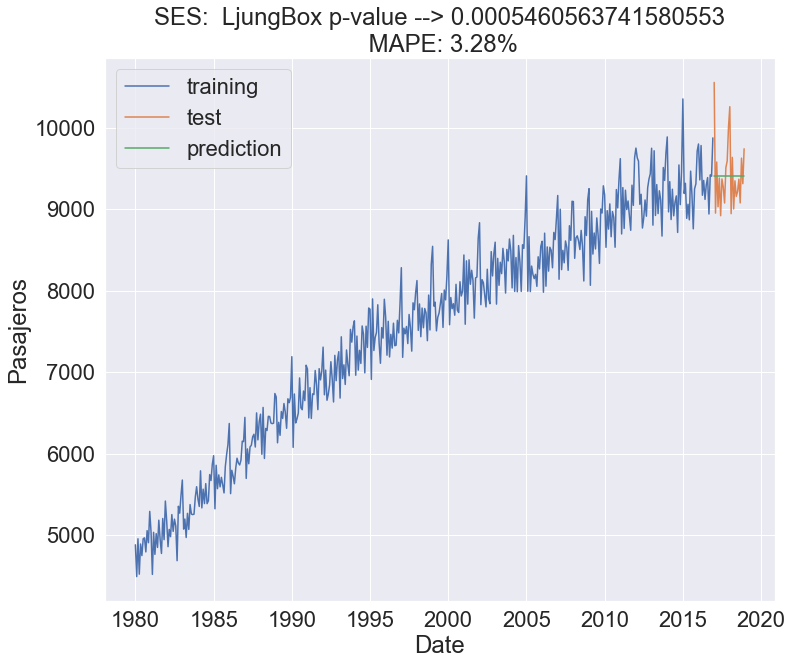

0.0005460563741580553


In [99]:
eval_model(ses,tumores_tr,tumores_tst,'SES')

### Modelo Suavizado doble de Holt

In [100]:
holt = ets.Holt(tumores_tr).fit()

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [101]:
holt.summary()

Dep. Variable:,Tumores,No. Observations:,444
Model:,Holt,SSE,45908589.334
Optimized:,True,AIC,5134.574
Trend:,Additive,BIC,5150.957
Seasonal:,None,AICC,5134.766
Seasonal Periods:,None,Date:,"Wed, 15 Mar 2023"
Box-Cox:,False,Time:,21:46:45
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3704814,alpha,True
smoothing_trend,0.1523200,beta,True


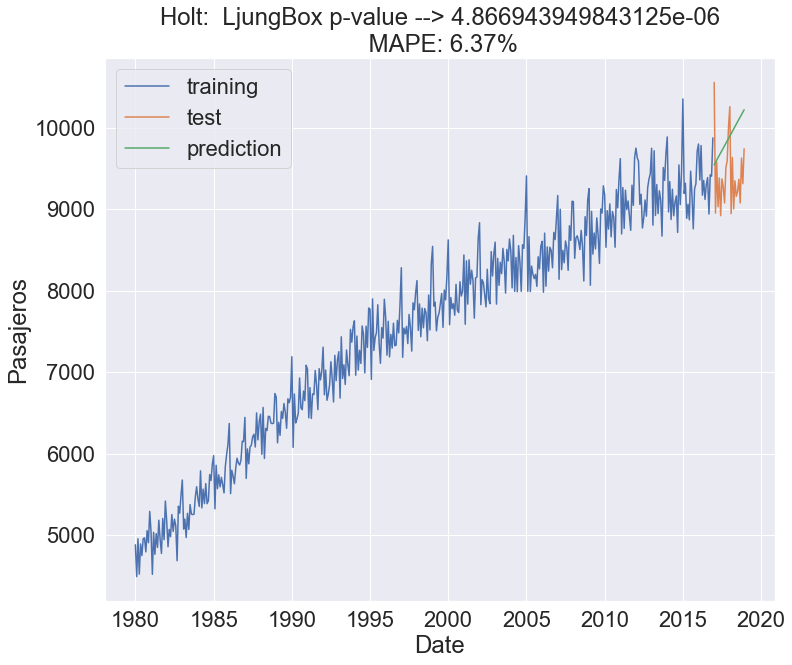

4.866943949843125e-06


In [102]:
eval_model(holt,tumores_tr,tumores_tst,'Holt')

### Suavizado de Holt Winters Aditivo

In [103]:
hw_add = ets.ExponentialSmoothing(tumores_tr,trend='add', damped_trend=False, seasonal='add').fit()

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [104]:
hw_add.summary()

Dep. Variable:,Tumores,No. Observations:,444
Model:,ExponentialSmoothing,SSE,10104812.627
Optimized:,True,AIC,4486.518
Trend:,Additive,BIC,4552.051
Seasonal:,Additive,AICC,4488.127
Seasonal Periods:,12,Date:,"Wed, 15 Mar 2023"
Box-Cox:,False,Time:,21:46:45
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1388963,alpha,True
smoothing_trend,0.0120084,beta,True


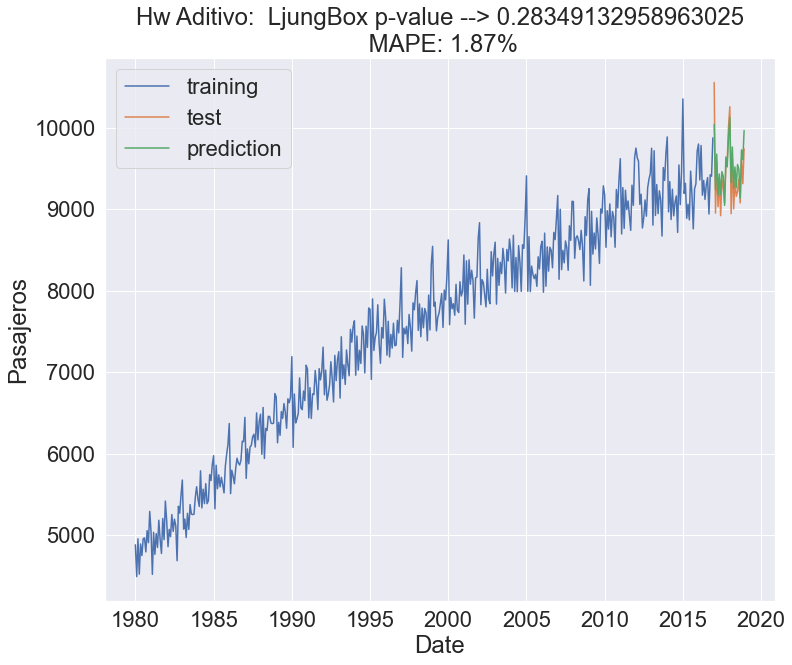

0.28349132958963025


In [105]:
eval_model(hw_add,tumores_tr,tumores_tst,'Hw Aditivo')

### Suavizado de Holt Winters Multiplicativo

In [106]:
hw_mul = ets.ExponentialSmoothing(tumores_tr,trend='mul', damped_trend=False, seasonal='mul').fit()

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning:

overflow encountered in matmul

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [107]:
hw_mul.summary()

Dep. Variable:,Tumores,No. Observations:,444
Model:,ExponentialSmoothing,SSE,10148938.091
Optimized:,True,AIC,4488.452
Trend:,Multiplicative,BIC,4553.986
Seasonal:,Multiplicative,AICC,4490.062
Seasonal Periods:,12,Date:,"Wed, 15 Mar 2023"
Box-Cox:,False,Time:,21:46:46
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1464286,alpha,True
smoothing_trend,0.0266234,beta,True


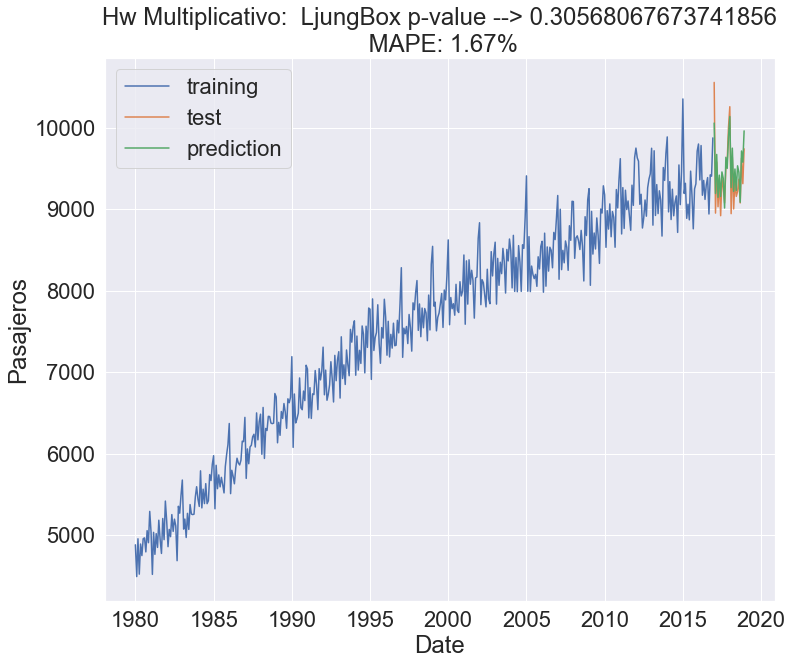

0.30568067673741856


In [108]:
eval_model(hw_mul,tumores_tr,tumores_tst,'Hw Multiplicativo')

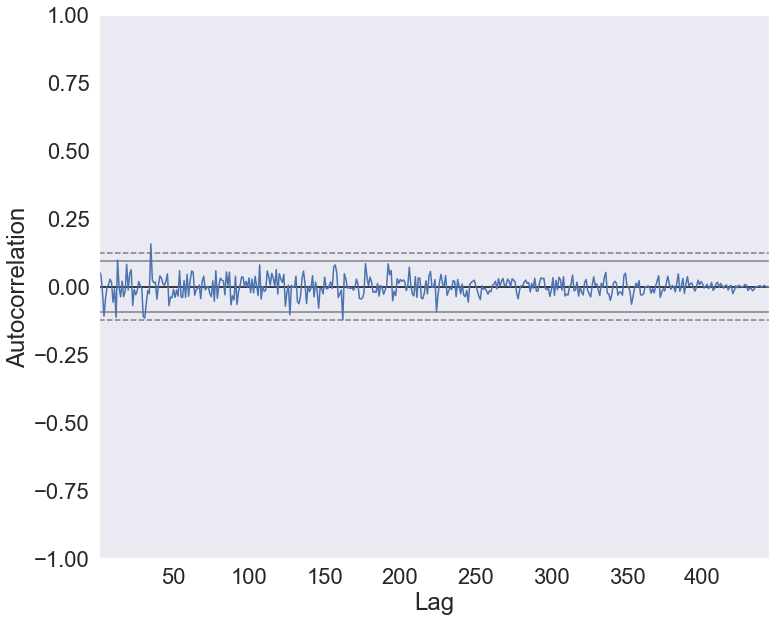

In [109]:
from pandas.plotting import autocorrelation_plot

plt.clf()
autocorrelation_plot(hw_mul.resid)
plt.show()

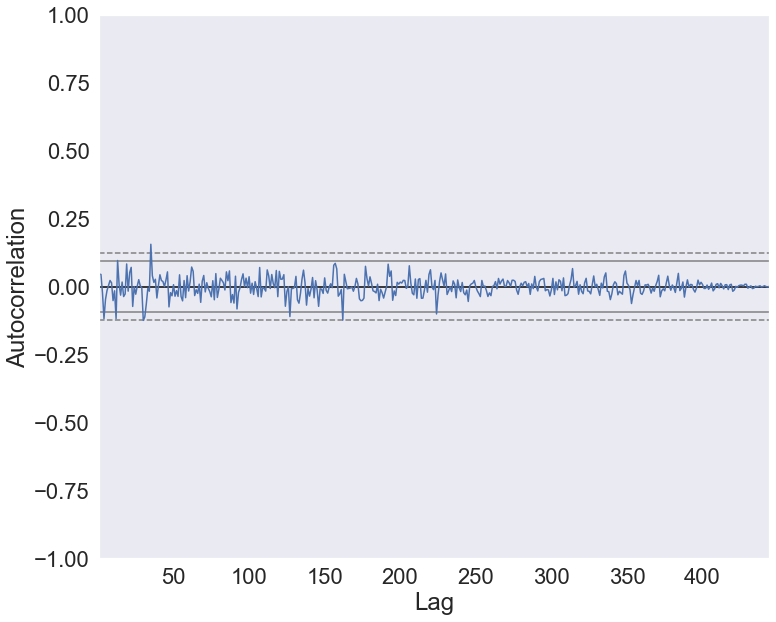

In [110]:
plt.clf()
autocorrelation_plot(hw_add.resid)
plt.show()

## Conclusiones sobre estos modelos

Por escoger, pareciera que el mejor modelo suavizado exponencial es el de **Holt Winters Miltiplicativo**, que curiosamente **no pasa el test residual de Ljung Box** y, sin embargo, contiene menor error porcentual absoluto medio, es el que mejor se ajusta a la prediccion de los datos y su distribución de los residuos contempla mejores resultados (por muy poco y de forma muy parecida al aditivo), seguido muy de cerca del mismo modelo pero en su versión aditiva, el cual, tomando en cuenta la correlación de residuos es mejor que el multiplicativo por su menor valor arrojado del test de Ljung Box.

### Modelos ARIMA

In [111]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
arima_propuesto = SARIMAX(tumores_tr, 
                order = (2, 1, 2), 
                seasonal_order =(2, 1, 1, 12))

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [112]:
arima_manual = arima_propuesto.fit()
arima_manual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              Tumores   No. Observations:                  444
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 12)   Log Likelihood               -2783.165
Date:                              Wed, 15 Mar 2023   AIC                           5582.330
Time:                                      21:46:58   BIC                           5614.859
Sample:                                  01-01-1980   HQIC                          5595.173
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0337      0.974      1.062      0.288      -0.875       2.942
ar.L2         -0.0737      0.083     -0.887      0.375      -0.236       0.089
ma.L1         -1.8325      0.969     -1.892      0.059      -3.731       0.066
ma.L2          0.8381      0.843      0.994      0.320      -0.814       2.491
ar.S.L12      -0.1425      0.063     -2.280      0.023      -0.265      -0.020
ar.S.L24      -0.0273      0.060     -0.452      0.651      -0.146       0.091
ma.S.L12      -0.7921      0.050    -15.914      0.000      -0.890      -0.695
sigma2      2.288e+04   1115.816     20.505      0.000    2.07e+04    2.51e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               138.18
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

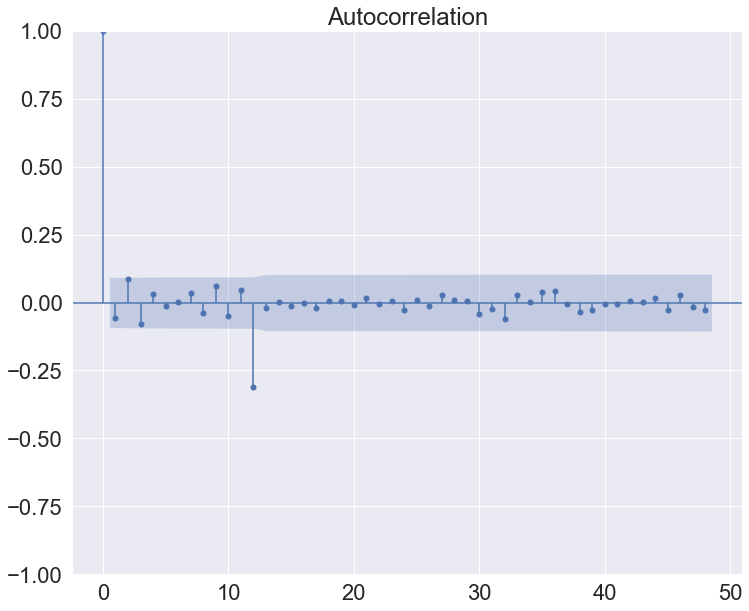

In [113]:
plot_acf(arima_manual.resid,lags=48)
plt.show()

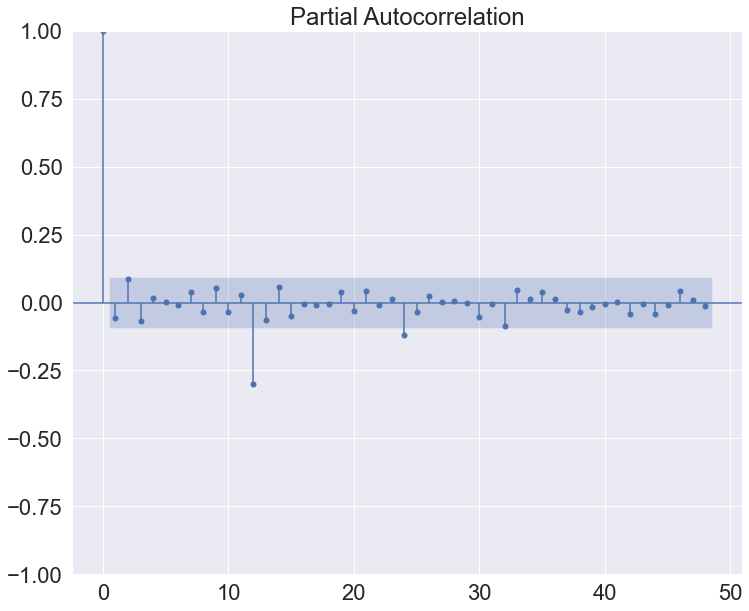

In [114]:
plot_pacf(arima_manual.resid,lags=48,method='ywm')
plt.show()

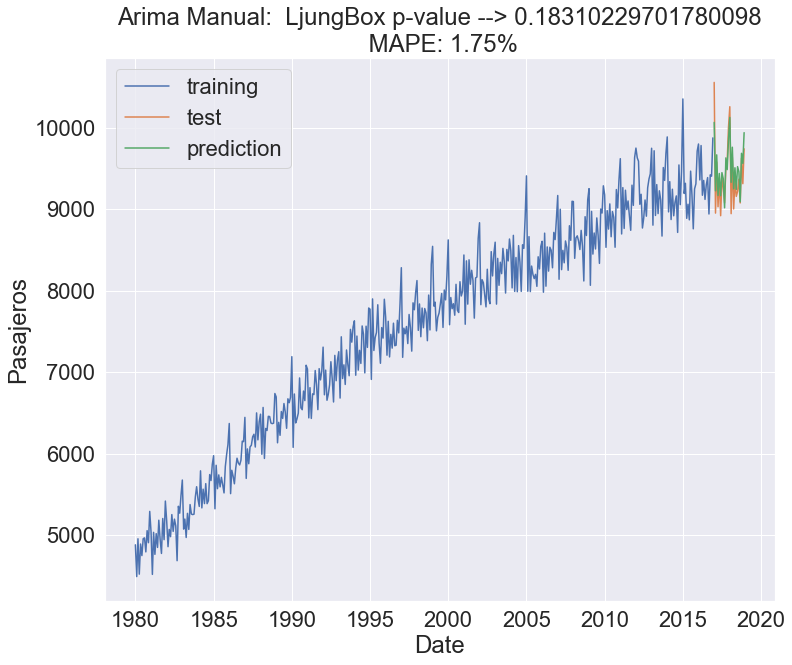

0.18310229701780098


In [115]:
eval_model(arima_manual,tumores_tr,tumores_tst,'Arima Manual')

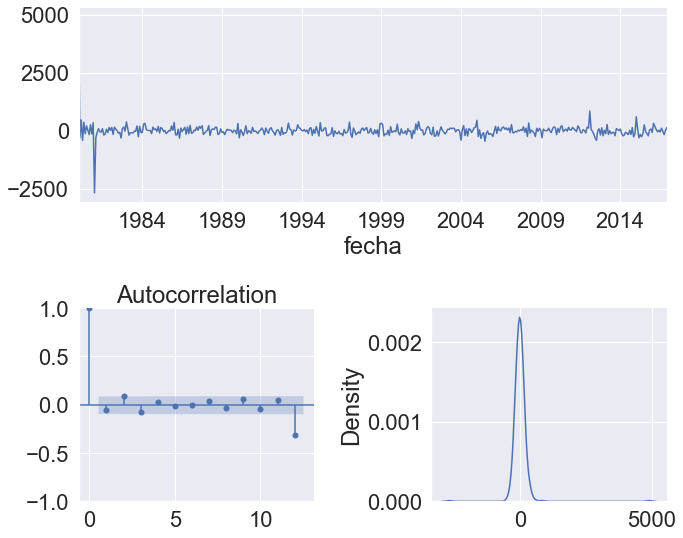

** Mean of the residuals:  -3.17

** Ljung Box Test, p-value: 0.183 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:xlabel='fecha'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [116]:
residcheck(arima_manual.resid,12)

### Modelo automatico

In [117]:
#!pip install pmdarima

In [118]:
import pmdarima as pm

# Ajustamos modelo arima step-wise con métrica AIC para la serie de vuelos
arima_auto = pm.auto_arima(tumores_tr, tumores_tst=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      #start_P=None, 
                      D=1, #colocar 1 ya que se identifico componente estacional
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=5577.127, Time=4.34 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6065.705, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5779.705, Time=0.49 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5579.503, Time=1.48 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=5579.534, Time=3.81 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=5680.669, Time=3.92 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=5578.950, Time=14.15 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=inf, Time=10.88 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=5816.496, Time=1.30 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=5577.004, Time=6.32 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5576.390, Time=4.49 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5579.688, Time=1.48 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=7.70 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5576.535, Time=2.92 sec
 ARIMA(0,1,1)(0,1,2)[12]   

In [119]:
print(arima_auto.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  444
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -2781.851
Date:                                 Wed, 15 Mar 2023   AIC                           5575.702
Time:                                         21:50:44   BIC                           5600.099
Sample:                                     01-01-1980   HQIC                          5585.335
                                          - 12-01-2016                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2833      0.162     -1.751      0.080      -0.600       0

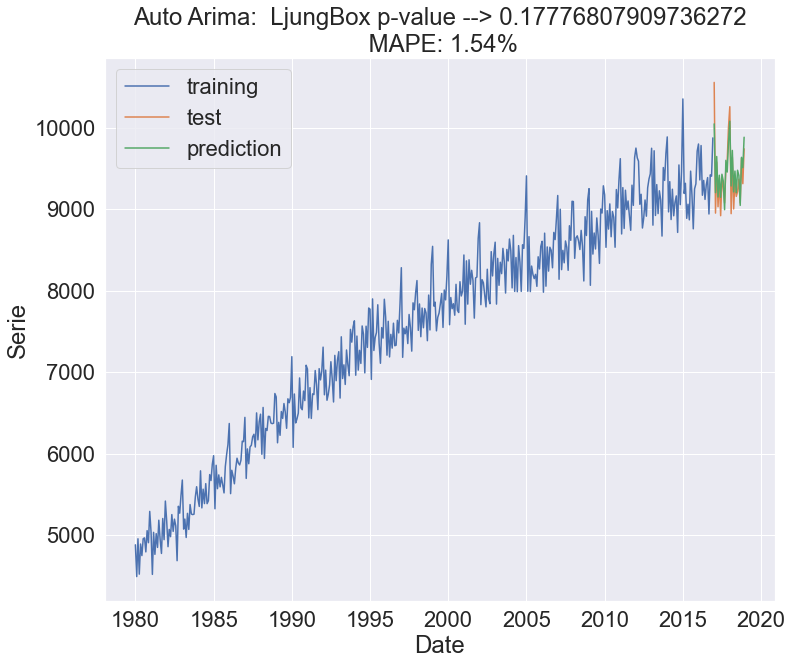

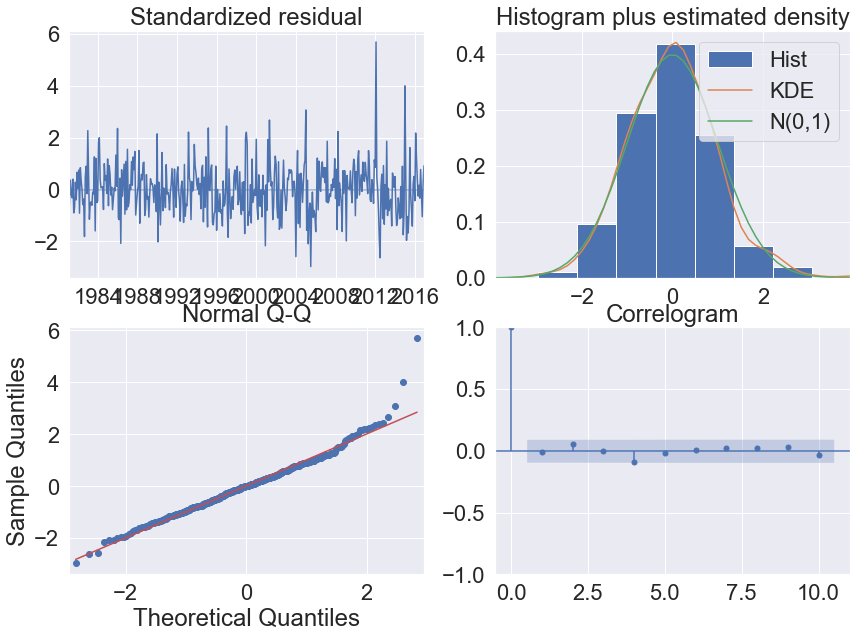

In [120]:
eval_model_Aarima(arima_auto,tumores_tr,tumores_tst,'Auto Arima')

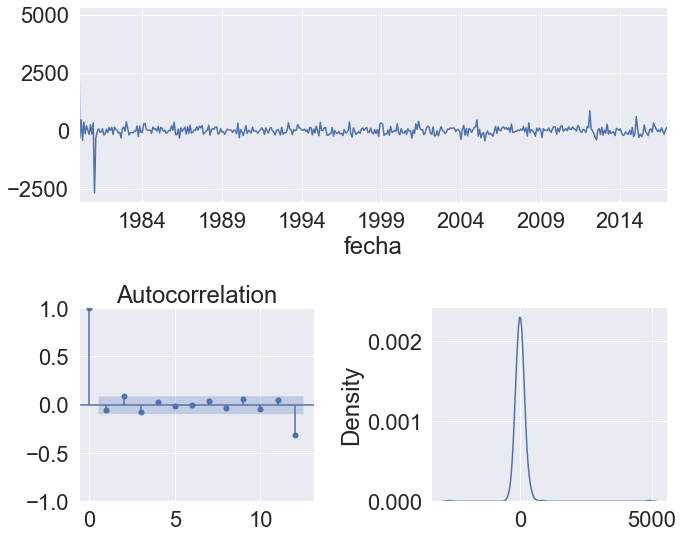

** Mean of the residuals:  7.03

** Ljung Box Test, p-value: 0.178 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:xlabel='fecha'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [121]:
residcheck(arima_auto.resid(),12)

## Conclusiones generales

El mejor modelo ARIMA es (1,1,1) (0,1,2)[12], con diferenciaciones en lo normal y estacional, obtenido automáticamente gracias a la maravillosa función. A pesar de que **no pasa el test de Ljung Box**, obtiene un valor de error pequeño y se aproxima muy bien a los datos de prueba (predicciones).

Si el Criterio es el valor del MAPE, el mejor modelo es el Modelo ARIMA (1,1,1) (0,1,2)[12], ya que obtiene el menor porcentaje de todos los modelos propuestos en este estudio. Igualmente, posee mejor valor  de correlación de residuos que los modelos de suavizados de Holt Winters Aditivo y Multiplicativo.